# **Model Training**

## Objectives

* Meet business requirement 2: "The Client wants to predict if a cherry tree is healthy or is infected with powerdy mildew"

## Inputs


-  inputs/cherry_leaves_dataset/train
-  inputs/cherry_leaves_dataset/test
-  inputs/cherry_leaves_dataset/validation
-  image shape


## Outputs


- Images distribution plot in train, validation, and test set
- Image augmentation
- Class indices to change prediction inference in labels
- Machine learning model creation and training
- Save model
- Learning curve plot for model performance
- Model evaluation on pickle file
- Prediction on the random image file




---

### Import Libraries

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import sklearn
import sklearn.metrics as metrics
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
import matplotlib as mpl
from matplotlib.image import imread

# Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [3]:
import os
current_dir = os.getcwd()
current_dir

'/workspaces/Mildew-Detection/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [4]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [5]:
current_dir = os.getcwd()
current_dir

'/workspaces/Mildew-Detection'

Set inputs and output paths

inputs:

In [7]:
my_data_dir = 'inputs/cherry_leaves/cherry-leaves'
train_path = my_data_dir + '/train'
val_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'

Outputs:

In [8]:

version = 'v2'

file_path = f'outputs/{version}'
version_file_path = os.path.join(current_dir, file_path)

if os.path.exists(version_file_path):
    print(f"version {version} already exists. Create a new version")
    pass
else:
    os.makedirs(name=file_path)


Set Labels

In [11]:

labels = sorted(os.listdir(train_path))
print('Label for the images are', labels)


Label for the images are ['healthy', 'powdery_mildew']


Set image shape

In [12]:

version = 'v1.0'
image_shape = joblib.load(filename=f"outputs/{version}/image_shape.pkl")
image_shape

(256, 256, 3)

# Confirm volume of images to data sets

* train - healthy: 1472 images
* train - powdery_mildew: 1472 images
* validation - healthy: 210 images
* validation - powdery_mildew: 210 images
* test - healthy: 422 images
* test - powdery_mildew: 422 images




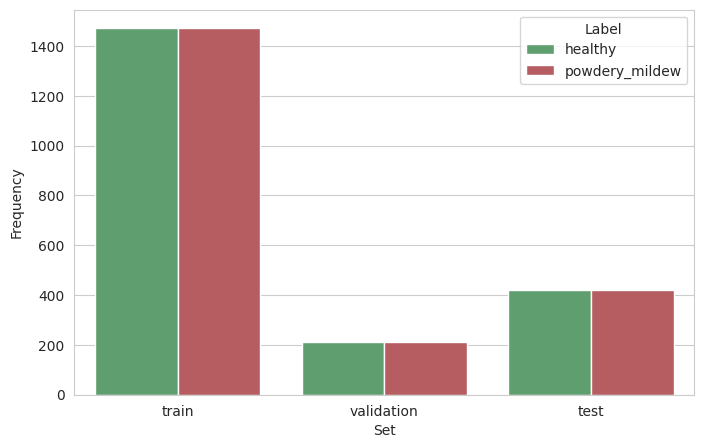

In [13]:
folders = ['train', 'validation', 'test']

df_freq = pd.DataFrame([{'Set': folder,
                         'Label': label,
                         'Frequency': sum(1 for _ in os.scandir(os.path.join(my_data_dir, folder, label)))}
                        for folder in folders
                        for label in labels])

for folder in folders:
    for label in labels:
        print(
            f"* {folder} - {label}: {df_freq[(df_freq['Set'] == folder) & (df_freq['Label'] == label)]['Frequency'].values[0]} images")

print("\n")
sns.set_style("whitegrid")
my_colors = ['#55A868', '#C44E52']
plt.figure(figsize=(8, 5))
sns.barplot(data=df_freq, x='Set', y='Frequency',
            hue='Label', palette=my_colors)
plt.savefig(f'{file_path}/labels_distribution.png',
            bbox_inches='tight', dpi=150)
plt.show()

### Image Data Augmentation

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [15]:

augmented_data = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
    rescale=1./255
)


In [16]:
batch_size = 32
data_color_mode = 'rgb'
data_class_mode = 'binary'

In [17]:

train_set = augmented_data.flow_from_directory(train_path,
                                               target_size=image_shape[:2],
                                               color_mode=data_color_mode,
                                               batch_size=batch_size,
                                               class_mode=data_class_mode,
                                               shuffle=True
                                               )

train_set.class_indices



Found 2944 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

In [18]:
validation_set = ImageDataGenerator(rescale=1./255).flow_from_directory(val_path,
                                                                        target_size=image_shape[:2],
                                                                        color_mode='rgb',
                                                                        batch_size=batch_size,
                                                                        class_mode='binary',
                                                                        shuffle=False
                                                                        )

validation_set.class_indices

Found 420 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

In [19]:
test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(test_path,
                                                                  target_size=image_shape[:2],
                                                                  color_mode='rgb',
                                                                  batch_size=batch_size,
                                                                  class_mode='binary',
                                                                  shuffle=False
                                                                  )

test_set.class_indices

Found 844 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

In [20]:
def plot_augmented_image(label_set, display_size=3):
    label_class = label_set.class_indices
    for _ in range(display_size):
        img, label = label_set.next()
        print(img.shape)
        img_class = list(label_class.keys())[
            list(label_class.values()).index(label[0])]
        plt.imshow(img[0])
        plt.axis('off')
        plt.title(img_class)
        plt.show()

(32, 256, 256, 3)


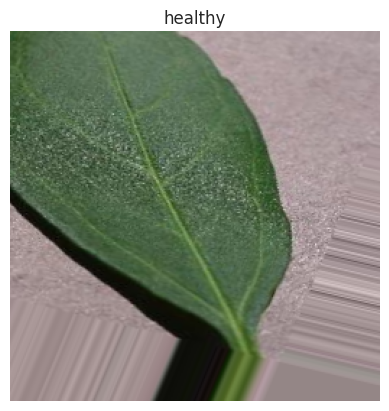

(32, 256, 256, 3)


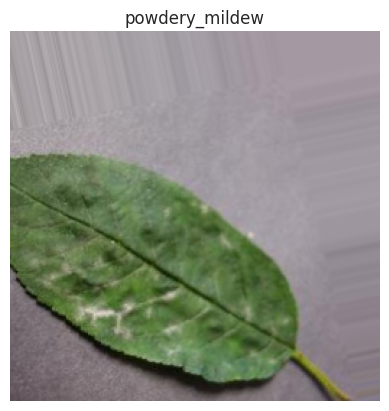

(32, 256, 256, 3)


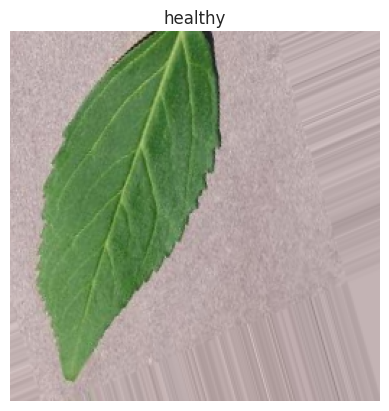

In [21]:
plot_augmented_image(train_set)

(32, 256, 256, 3)


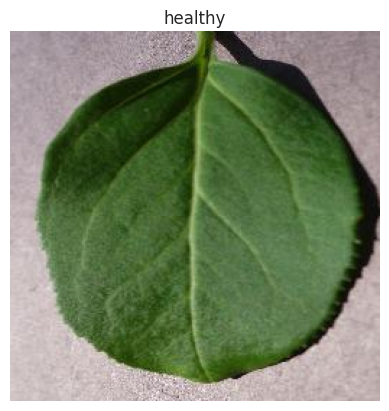

(32, 256, 256, 3)


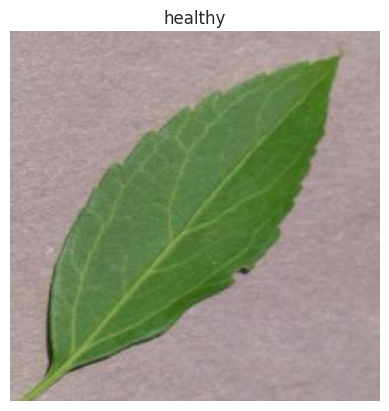

(32, 256, 256, 3)


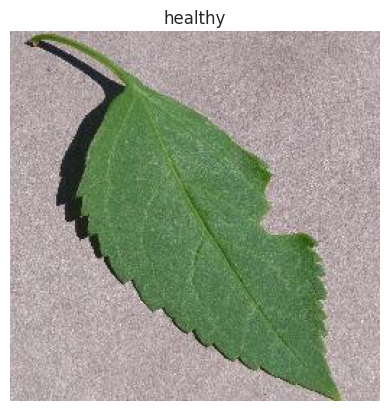

In [22]:
plot_augmented_image(validation_set)

(32, 256, 256, 3)


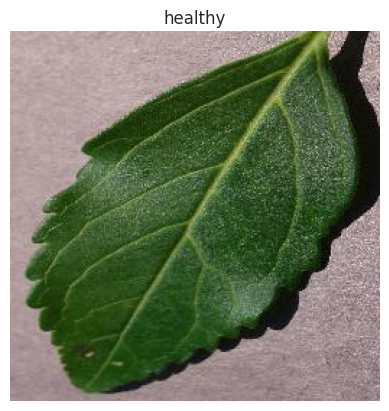

(32, 256, 256, 3)


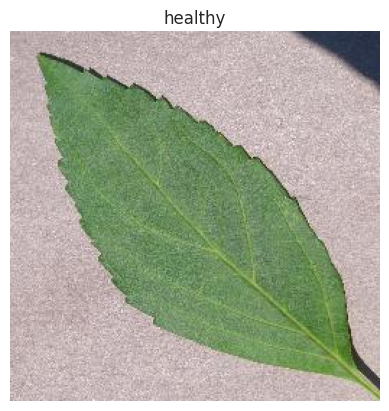

(32, 256, 256, 3)


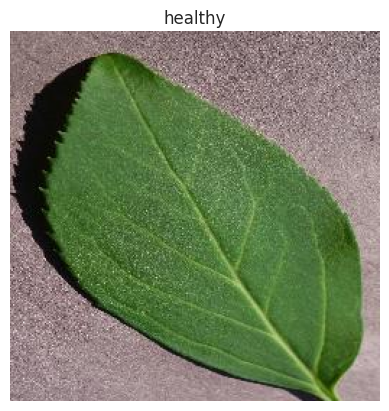

In [23]:
plot_augmented_image(test_set)

---

# Creating the Model

Import the Machine Learning package

In [24]:
! pip install keras-tuner

In [25]:
from tensorflow import keras
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from keras.regularizers import l2

In [26]:
def model_builder(hp):

    model = Sequential()

    model.add(Conv2D(filters=2, kernel_size=(3, 3), input_shape=image_shape,
                     activation='relu',))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=4, kernel_size=(3, 3), input_shape=image_shape,
                     activation='relu',))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=8, kernel_size=(3, 3), input_shape=image_shape,
                     activation='relu',))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())

    hp_units = hp.Int('units', min_value=16, max_value=64, step=16)
    model.add(Dense(units=hp_units, activation='relu',
              kernel_regularizer=l2(0.001)))

    model.add(Dropout(0.5))
    model.add(Dense(1, activation='tanh'))
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-3, 1e-4])
    opt = keras.optimizers.Adam(learning_rate=hp_learning_rate)

    model.compile(loss='binary_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])

    return model


Optimisation techniques

• Dropout is a regularization technique used to prevent overfitting. It randomly drops out some of the units in the network during training, which helps to prevent co-adaptation of neurons and encourages the network to learn more robust features.

• Hyperparameter search is the process of finding the optimal values for the hyperparameters of a neural network. In this function, we use two hyperparameters - the number of units in the dense layer and the learning rate of the optimizer. We use the hp.Int method to search for the optimal number of units and the hp.Choice method to select the learning rate from a set of predefined values.

• Regularization is used to prevent overfitting. In this function, we use L2 regularization, which adds a penalty term to the loss function that encourages the weights of the network to stay small.

• Adam Optimizer: Adam is an adaptive optimization algorithm, it uses a combination of momentum and adaptive learning rates to minimize the loss function efficiently.


In [27]:

tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory=file_path,
                     project_name='hypertuning'
                     )


2023-08-06 14:30:46.695257: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [28]:
early_stop = EarlyStopping(monitor='val_loss', patience=3)

In [29]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(
    'balanced',
    np.unique(train_set.classes),
    train_set.classes)

train_class_weights = dict(enumerate(class_weights))
train_class_weights

{0: 1.0, 1: 1.0}

In [30]:
tuner.search(train_set,
             epochs=25,
             steps_per_epoch=len(train_set.classes) // batch_size,
             validation_data=validation_set,
             class_weight=train_class_weights,
             callbacks=[early_stop],
             verbose=2)

optimal_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the
first densely-connected layer is {optimal_hps.get('units')} and the optimal
learning rate for the optimizer is {optimal_hps.get('learning_rate')}.
""")

Trial 8 Complete [00h 03m 20s]
val_accuracy: 0.28809523582458496

Best val_accuracy So Far: 0.9809523820877075
Total elapsed time: 00h 31m 14s
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. The optimal number of units in the
first densely-connected layer is 48 and the optimal
learning rate for the optimizer is 0.001.



In [31]:
model = tuner.hypermodel.build(optimal_hps)

In [32]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 254, 254, 2)       56        
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 127, 127, 2)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 125, 125, 4)       76        
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 62, 62, 4)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 60, 60, 8)         296       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 30, 30, 8)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 7200)             

In [33]:
model.fit(train_set,
          epochs=20,
          steps_per_epoch=len(train_set.classes) // batch_size,
          validation_data=validation_set,
          class_weight=train_class_weights,
          callbacks=[early_stop],
          verbose=1)

Epoch 1/20
92/92 [==============================] - 103s 1s/step - loss: 1.1541 - accuracy: 0.5340 - val_loss: 0.8919 - val_accuracy: 0.8500
Epoch 2/20
92/92 [==============================] - 101s 1s/step - loss: 0.6827 - accuracy: 0.8094 - val_loss: 0.3380 - val_accuracy: 0.9167
Epoch 3/20
92/92 [==============================] - 103s 1s/step - loss: 0.4035 - accuracy: 0.8832 - val_loss: 0.3847 - val_accuracy: 0.9595
Epoch 4/20
92/92 [==============================] - 100s 1s/step - loss: 0.3509 - accuracy: 0.9171 - val_loss: 0.3634 - val_accuracy: 0.9405
Epoch 5/20
92/92 [==============================] - 102s 1s/step - loss: 0.3000 - accuracy: 0.9436 - val_loss: 0.3018 - val_accuracy: 0.9357
Epoch 6/20
92/92 [==============================] - 101s 1s/step - loss: 0.2484 - accuracy: 0.9538 - val_loss: 0.6108 - val_accuracy: 0.8976
Epoch 7/20
92/92 [==============================] - 101s 1s/step - loss: 0.3782 - accuracy: 0.8971 - val_loss: 0.6643 - val_accuracy: 0.8524
Epoch 8/20
92

Save the Model

In [34]:
model.save(f'{file_path}/mildew_detector_model.h5')

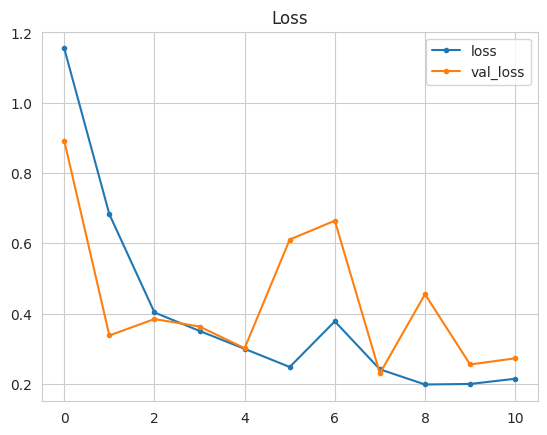

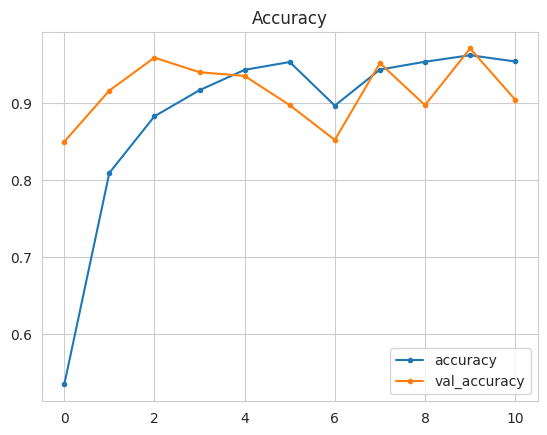

In [35]:


losses = pd.DataFrame(model.history.history)

sns.set_style("whitegrid")
losses[['loss', 'val_loss']].plot(style='.-')
plt.title("Loss")
plt.savefig(f'{file_path}/model_training_losses.png',
            bbox_inches='tight', dpi=150)
plt.show()

print("\n")
losses[['accuracy', 'val_accuracy']].plot(style='.-')
plt.title("Accuracy")
plt.savefig(f'{file_path}/model_training_acc.png',
            bbox_inches='tight', dpi=150)
plt.show()



Model Evaluation

In [36]:
from keras.models import load_model
model = load_model(f'{file_path}/mildew_detector_model.h5')
print(f'{file_path}/mildew_detector_model.h5')

outputs/v2/mildew_detector_model.h5


In [37]:
evaluation = model.evaluate(test_set)
print("Model accuracy: {:.2f}%".format(evaluation[1] * 100))

27/27 [==============================] - 12s 455ms/step - loss: 0.2800 - accuracy: 0.9052
Model accuracy: 90.52%


In [38]:
joblib.dump(value=evaluation, filename=f'{file_path}/evaluation.pkl')

['outputs/v2/evaluation.pkl']

## ROC curve



The ROC curve shows the relationship between the TPR and FPR for various classification thresholds.

The AUC is a metric that measures the overall performance of the classifier.


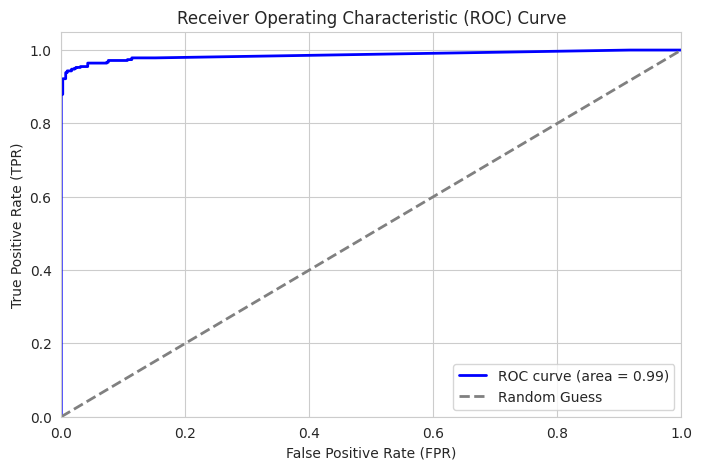

In [39]:
from sklearn.metrics import roc_curve, auc

pred = model.predict(test_set)

fpr, tpr, thresholds = roc_curve(test_set.classes, pred)

roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, color='blue', lw=2,
         label=f'ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='grey', lw=2,
         linestyle='--', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.savefig(f'{file_path}/roc_curve.png', bbox_inches='tight', dpi=150)

Confusion Matrix

A classification report and a confusion matrix

precision    recall  f1-score   support

       Healthy       0.84      1.00      0.91       422
Powdery Mildew       1.00      0.81      0.90       422

      accuracy                           0.91       844
     macro avg       0.92      0.91      0.90       844
  weighted avg       0.92      0.91      0.90       844



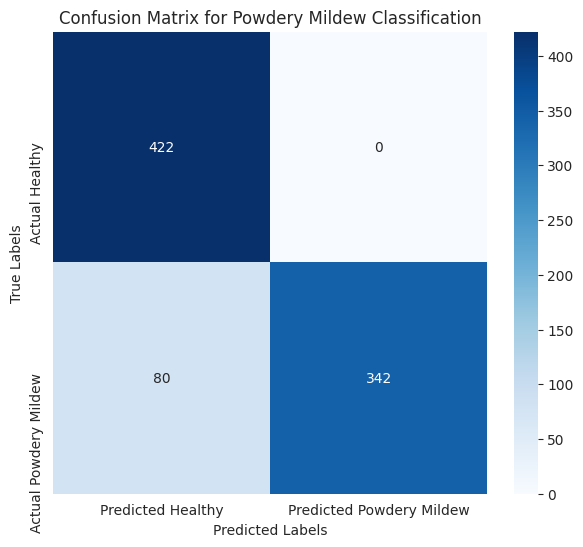

In [40]:

y_pred = np.round(pred).astype(int)

target_names = ['Healthy', 'Powdery Mildew']
confusion_mat = confusion_matrix(test_set.classes, y_pred)


plt.figure(figsize=(7, 6))
sns.heatmap(confusion_mat,
            annot=True,
            fmt='g',
            cmap='Blues',
            xticklabels=['Predicted Healthy', 'Predicted Powdery Mildew'],
            yticklabels=['Actual Healthy', 'Actual Powdery Mildew'])
plt.title('Confusion Matrix for Powdery Mildew Classification')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.savefig(f'{file_path}/confusion_matrix.png', bbox_inches='tight', dpi=150)

clf_report = classification_report(
    test_set.classes, y_pred, target_names=target_names)

print(clf_report)

Classification Plot

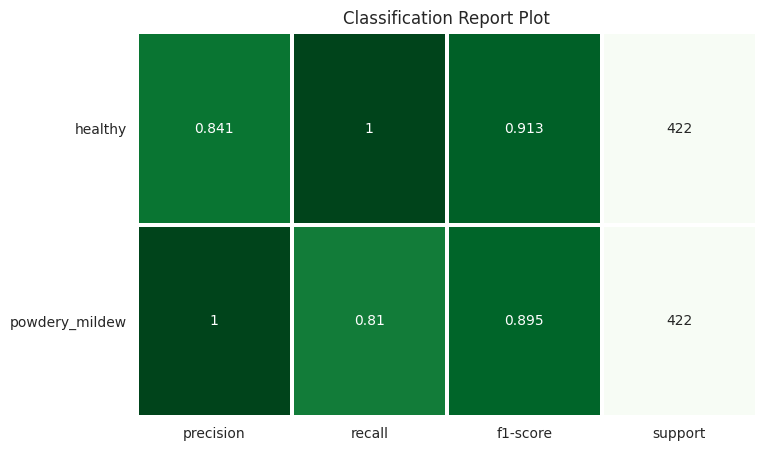

In [41]:
clf_report = classification_report(
    test_set.classes, y_pred, target_names=labels, output_dict=True)

keys_to_plot = [key for key in clf_report.keys() if key not in (
    'accuracy', 'macro avg', 'weighted avg')]
df = pd.DataFrame(clf_report, columns=keys_to_plot).T
df = df.sort_values(by=['support'], ascending=True)

mask = np.zeros(df.shape)
mask[:, -1] = True
cmap = 'Greens'
norm = mpl.colors.Normalize(vmin=df['support'].min(), vmax=df['support'].sum())

fig, ax = plt.subplots(figsize=(8, 5))
ax = sns.heatmap(df, mask=mask, annot=True, cmap=cmap, fmt='.3g',
                 cbar=False, linewidths=.4, linecolor='white', vmin=0.0, vmax=1.0)

mask = np.zeros(df.shape)
mask[:, :-1] = True
ax = sns.heatmap(df, mask=mask, annot=True, cmap=cmap, cbar=False, linewidths=2,
                 linecolor='white', fmt='.0f', vmin=df['support'].min(), vmax=df['support'].sum(), norm=norm)

plt.title('Classification Report Plot')
if labels is not None:
    classes = labels
else:
    classes = [str(i) for i in range(len(df.index))]
plt.yticks(np.arange(len(classes))+.5, classes, rotation=0)


plt.savefig(f'{file_path}/classification_report.png',
            bbox_inches='tight', dpi=150)

Fresh Data prediction

Image shape: (256, 256), Image mode: RGB


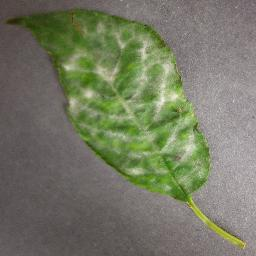

In [42]:
from tensorflow.keras.preprocessing import image

pointer = 32
label = labels[1]  
pil_image = image.load_img(test_path + '/' + label + '/' + os.listdir(test_path+'/' + label)[pointer],
                           target_size=image_shape, color_mode='rgb')
print(f'Image shape: {pil_image.size}, Image mode: {pil_image.mode}')
pil_image

In [43]:
my_image = image.img_to_array(pil_image)
my_image = np.expand_dims(my_image, axis=0)/255
print(my_image.shape)

(1, 256, 256, 3)


Prediction:

In [44]:


prediction_probability = model.predict(my_image)[0, 0]

target_map = {v: k for k, v in train_set.class_indices.items()}
predicted_class = target_map[prediction_probability > 0.5]
if predicted_class == target_map[0]:
    prediction_probability = 1 - prediction_probability

print(f'Prediction probability: {round(prediction_probability*100, 2)}%')
print(f'Predicted class: {predicted_class}')



Prediction probability: 98.18%
Predicted class: powdery_mildew


---